<a href="https://colab.research.google.com/github/AlePol27/2022_ML_Earth_Env_Sci/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML final project - Feature importance on landslide prediction

## Part I: Load data

This cell contains an initial set up.

*Source: Prof. Tom Beucler's notebooks</a>.*

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

The necessary datasets are stored on Google Drive. The next cells allow the data to be retrieved and loaded into the notebook.

*Source: <a href="https://sigmundojr.medium.com/how-do-i-read-a-csv-file-from-google-drive-using-python-colab-966091922852">Sigmundo Preissler Jr, PhD</a>.*

Required imports:

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Authentication with Google account:

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Creation of the files:

In [4]:
fileDownloaded1 = drive.CreateFile({'id':'1VtBalvWeWV2WtEPf5M19XP8sSnxAG135'})
fileDownloaded2 = drive.CreateFile({'id':'1ib9MgVkaqnEPlX8m-dRN1s4Ys7PL5aEg'})

Import of .csv data files:

In [5]:
fileDownloaded1.GetContentFile('LS_good_5m_pro.csv')
fileDownloaded2.GetContentFile('testDF.csv')

Generation of Pandas dataframes:

In [6]:
import pandas as pd
vardf = pd.read_csv('LS_good_5m_pro.csv', delimiter=',')
testdf = pd.read_csv('testDF.csv', delimiter=',')

Finally, it's possible to create a geodataframe for each of the two imported files (with Geopandas).

*Code adapted from: Prof. Tom Beucler's notebooks</a>.*

In [ ]:
%pip install geopandas
import geopandas as gpd

In [8]:
vardf = gpd.GeoDataFrame(vardf,
                      geometry=gpd.points_from_xy(np.float64(vardf.x), 
                                                  np.float64(vardf.y)))
vardf.head()

,x,y,GSS,DEM,slope,planCurv,profCurv,distRoad,landCover,TWI,geology,geometry
0,567895.5,200099.5,1,437.746155,8.737924,-0.000748,0.012272,145.000000,21,7.799716,24,POINT (567895.500 200099.500)
1,568095.5,200079.5,1,451.840485,10.511221,0.039531,-0.080413,5.000000,11,4.903382,24,POINT (568095.500 200079.500)
2,567905.5,200044.5,1,459.606934,23.602930,0.020892,-0.144569,98.994949,15,4.046845,24,POINT (567905.500 200044.500)
3,567950.5,200029.5,1,458.156433,13.160677,0.040629,-0.046540,56.568542,15,5.365241,24,POINT (567950.500 200029.500)
4,567800.5,199999.5,1,460.311768,20.403830,-0.005813,-0.020053,138.654251,21,5.817281,24,POINT (567800.500 199999.500)


In [9]:
testdf = gpd.GeoDataFrame(testdf,
                      geometry=gpd.points_from_xy(np.float64(testdf.x), 
                                                  np.float64(testdf.y)))
testdf.head()

,Unnamed: 0,x,y,GSS,prediction,geometry
0,1,567895.5,200099.5,1,0.196,POINT (567895.500 200099.500)
1,2,568095.5,200079.5,1,0.864,POINT (568095.500 200079.500)
2,3,567905.5,200044.5,1,0.998,POINT (567905.500 200044.500)
3,4,567950.5,200029.5,1,0.990,POINT (567950.500 200029.500)
4,5,567800.5,199999.5,1,0.822,POINT (567800.500 199999.500)


## Part II: Preprocessing

In this section two tables are created: one with predictive variables and one with the landslides prediction.

For the first table, the 8 predictor variables are selected and put into a geodataframe:

In [10]:
DEM = vardf.DEM
slope = vardf.slope
planCurv = vardf.planCurv
profCurv = vardf.profCurv
distRoad = vardf.distRoad
landCover = vardf.landCover
TWI = vardf.TWI
geology = vardf.geology

In [14]:
data = gpd.GeoDataFrame({'DEM':DEM, 'slope':slope, 'planCurv':planCurv, 'profCurv':profCurv, 'distRoad':distRoad, 'landCover':landCover, 'TWI':TWI, 'geology':geology})
data

,DEM,slope,planCurv,profCurv,distRoad,landCover,TWI,geology
0,437.746155,8.737924,-0.000748,0.012272,145.000000,21,7.799716,24
1,451.840485,10.511221,0.039531,-0.080413,5.000000,11,4.903382,24
2,459.606934,23.602930,0.020892,-0.144569,98.994949,15,4.046845,24
3,458.156433,13.160677,0.040629,-0.046540,56.568542,15,5.365241,24
4,460.311768,20.403830,-0.005813,-0.020053,138.654251,21,5.817281,24
...,...,...,...,...,...,...,...,...
5183,451.893799,1.660977,-0.005359,0.001711,241.298569,21,12.846220,1
5184,2197.191650,25.800716,0.093662,-0.004219,1674.820923,51,3.945750,7
5185,628.142700,37.131775,-0.026372,0.002024,189.274933,41,4.883382,1
5186,445.515076,0.898599,0.003541,-0.002232,98.615417,15,9.319879,9


For the second table, the prediction for each observation is reported:

In [15]:
pred_data = testdf.prediction
pred = gpd.GeoDataFrame({'pred': pred_data})
pred

,pred
0,0.196
1,0.864
2,0.998
3,0.990
4,0.822
...,...
5183,0.002
5184,0.050
5185,0.418
5186,0.046


The two tables are joined to delete eventual NaN data:

In [16]:
data_pred = pd.concat([data, pred], axis=1, join="inner")
data_pred.dropna()
data_pred

,DEM,slope,planCurv,profCurv,distRoad,landCover,TWI,geology,pred
0,437.746155,8.737924,-0.000748,0.012272,145.000000,21,7.799716,24,0.196
1,451.840485,10.511221,0.039531,-0.080413,5.000000,11,4.903382,24,0.864
2,459.606934,23.602930,0.020892,-0.144569,98.994949,15,4.046845,24,0.998
3,458.156433,13.160677,0.040629,-0.046540,56.568542,15,5.365241,24,0.990
4,460.311768,20.403830,-0.005813,-0.020053,138.654251,21,5.817281,24,0.822
...,...,...,...,...,...,...,...,...,...
5183,451.893799,1.660977,-0.005359,0.001711,241.298569,21,12.846220,1,0.002
5184,2197.191650,25.800716,0.093662,-0.004219,1674.820923,51,3.945750,7,0.050
5185,628.142700,37.131775,-0.026372,0.002024,189.274933,41,4.883382,1,0.418
5186,445.515076,0.898599,0.003541,-0.002232,98.615417,15,9.319879,9,0.046


## Part III: Random Forest Regressor implementation

General implementation of Random forest regressor:

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, pred, test_size = 0.33, random_state = rnd_seed)

In [18]:
from sklearn.ensemble import RandomForestRegressor
regr1 = RandomForestRegressor(max_depth=10, random_state=0)
regr1.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(max_depth=10, random_state=0)

The mean squared error and the coefficient of determination are calculated. *Source: <a href="https://stackoverflow.com/questions/55942884/how-to-get-accuracy-in-randomforest-model-in-python">Stackoverflow</a>.*

In [29]:
#from sklearn.metrics import accuracy_score
import math
y_pred1 = regr1.predict(X_test)
#accuracy = regr1.score(y_pred, y_test)
mse1 = sklearn.metrics.mean_squared_error(y_test, y_pred1)
print(f'The mean squared error of the RandomForest Regression is {mse1}')
r2 = sklearn.metrics.r2_score(y_test, y_pred1, sample_weight=None, multioutput='uniform_average')
print (r2)

The mean squared error of the RandomForest Regression is 0.009039789731977613
0.9209918832658137


In this section, an hyperparameters search is conducted to reduce the error and to get a better R2:

In [ ]:
from sklearn.model_selection import GridSearchCV
param = {'n_estimators': [30, 40, 50, 60], 'max_features': [1, 2, 3, 4, 5]}
gscv = GridSearchCV(regr1, param, cv = 5)
gscv.fit(X_train, y_train)

In [31]:
gscv.best_params_
best_grid = gscv.best_estimator_
best_grid

RandomForestRegressor(max_depth=10, max_features=4, n_estimators=60,
                      random_state=0)

In [ ]:
# Just an essay in case the previous code isn't enough
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = regr1, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Just an essay in case the previous code isn't enough
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

best_grid = grid_search.best_estimator_
best_grid
#base_accuracy = evaluate(regr1, X_test, y_test)
#grid_accuracy = evaluate(best_grid, X_test, y_test)

#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Here the Random forest regressor is implemented with the parameters found above:

In [ ]:
regr2 = RandomForestRegressor(n_estimators = 60, max_features = 4)
regr2.fit(X_train, y_train)

The mean squared error and the coefficient of determination are calculated. Source: Stackoverflow.

In [37]:
import math
y_pred2 = regr2.predict(X_test)
#accuracy = regr1.score(y_pred, y_test)
mse2 = sklearn.metrics.mean_squared_error(y_test, y_pred2)
#rmse = math.sqrt(mse)
print(f'The mean squared error of the RandomForest Regression is {mse2}')
r2 = sklearn.metrics.r2_score(y_test, y_pred2, sample_weight=None, multioutput='uniform_average')
print (r2)

The mean squared error of the RandomForest Regression is 0.007833408940131025
0.9315356986922865


##Part IV: Feature importance

First method for Feature importance - mean decrease in impurity.
*Source: <a href="https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html">scikit-learn</a>.*

In [38]:
importances = regr2.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr2.estimators_], axis=0)
feature_names = [data.columns]

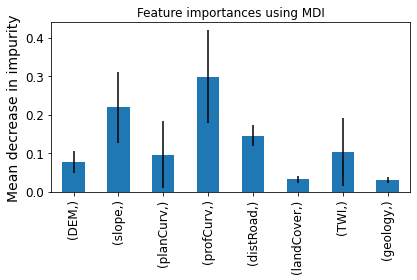

In [39]:
forest_importances_1 = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances_1.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Varibles with a mean >= 0.1 are listed here:

In [40]:
var_import_1 = forest_importances_1[forest_importances_1 >= 0.1]
var_import_1

slope       0.219095
profCurv    0.297831
distRoad    0.145626
TWI         0.101977
dtype: float64

Second method for Feature importance - feature permutation. *Source: <a href="https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html">scikit-learn</a>.*

In [41]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    regr2, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances_2 = pd.Series(result.importances_mean, index=feature_names)

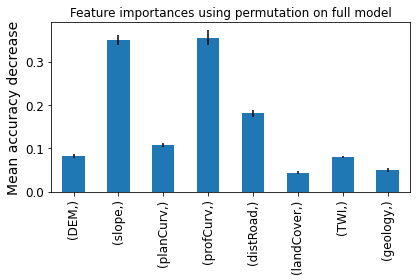

In [42]:
fig, ax = plt.subplots()
forest_importances_2.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Varibles with a mean >= 0.15 are listed here:

In [43]:
var_import_2 = forest_importances_2[forest_importances_2 >= 0.15]
var_import_2

slope       0.349763
profCurv    0.355464
distRoad    0.180295
dtype: float64

Domanda di ricerca: 
è effettivamente possibile ridurre i parametri di predizione delle frane?